In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import pandas as pd
import numpy as np
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.mixed_effects_human import MixedEffectsHuman
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

DATASET_REAL = 'real_data/dnc_info_2022-05-26.parquet'
DATASET_REAL_METADATA = 'dnc_info_2022-05-26_settings.json'

df = pd.read_parquet(os.path.join(data.data_path, DATASET_REAL))
df = data.clean_human_data(df)

# participants = ["cornptio012", "cornptio013", "cornptio015", "scapptio001"]
# idx = df.participant.isin(participants)
# df = df[idx].reset_index(drop=True).copy()

df, encoder_dict = data.build(df)

2023-04-21 15:12:30,931 - hb_mep.utils.utils - INFO - func:clean_human_data took: 0.19 sec
2023-04-21 15:12:30,933 - hb_mep.data_access.core - INFO - Processing data ...
2023-04-21 15:12:30,951 - hb_mep.utils.utils - INFO - func:preprocess took: 0.02 sec
2023-04-21 15:12:30,952 - hb_mep.utils.utils - INFO - func:build took: 0.02 sec


In [5]:
# combinations = [("cornptio017", "C4", "L")]
# idx = \
#     df.apply(lambda x: (x.participant, x.sc_level, x.sc_laterality), axis=1) \
#     .isin(combinations)


#### Plot

In [6]:
# plot(df=df, encoder_dict=encoder_dict);

#### Initialize model

In [7]:
model = MixedEffectsHuman(config)

#### Run MCMC inference

In [8]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-04-21 15:12:31,454 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-04-21 15:12:31,455 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-04-21 15:12:31,455 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-04-21 15:12:31,456 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-04-21 15:12:31,457 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-04-21 15:12:31,507 - hb_mep.models.mixed_effects_human - INFO - Running inference with Mixed_E

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

2023-04-21 15:14:52,024 - hb_mep.utils.utils - INFO - func:run_inference took: 2 min and 20.58 sec


#### Diagnostics

In [9]:
mcmc.print_summary(prob=.95)


                                   mean       std    median      2.5%     97.5%     n_eff     r_hat
                       b[0,0]      2.96      2.51      2.33      0.00      7.83   8833.95      1.00
                       b[0,1]      3.24      2.51      2.72      0.00      8.06   9389.71      1.00
                       b[0,2]      3.29      2.50      2.81      0.00      7.98  11351.23      1.00
                       b[0,3]      3.21      2.51      2.70      0.00      7.85   9176.98      1.00
                       b[0,4]      3.25      2.51      2.75      0.00      7.98   8696.70      1.00
                       b[0,5]      0.32      0.05      0.32      0.23      0.41   8696.73      1.00
                       b[0,6]      3.29      2.50      2.81      0.00      8.04   9663.63      1.00
                       b[0,7]      1.68      0.12      1.67      1.44      1.93   7207.54      1.00
                       b[0,8]      1.21      0.07      1.21      1.09      1.34   6088.68      1.00

#### Plot fitted curves

In [11]:
posterior_samples["a"].mean(axis=0)

Array([[10.80317154,  8.85160862, 10.58653144, 12.9146646 , 12.95209268,
         0.39654469, 11.94608963,  3.02169453,  0.49598532, 12.1639781 ,
         2.03172272,  2.96777652,  1.84682053],
       [18.52048536, 16.39387583, 18.13183246, 20.49656793, 20.54377251,
         9.65605367, 19.47796569, 11.23984678, 10.57465914, 19.70811034,
         7.27615016, 10.82527914,  6.76636378]], dtype=float64)

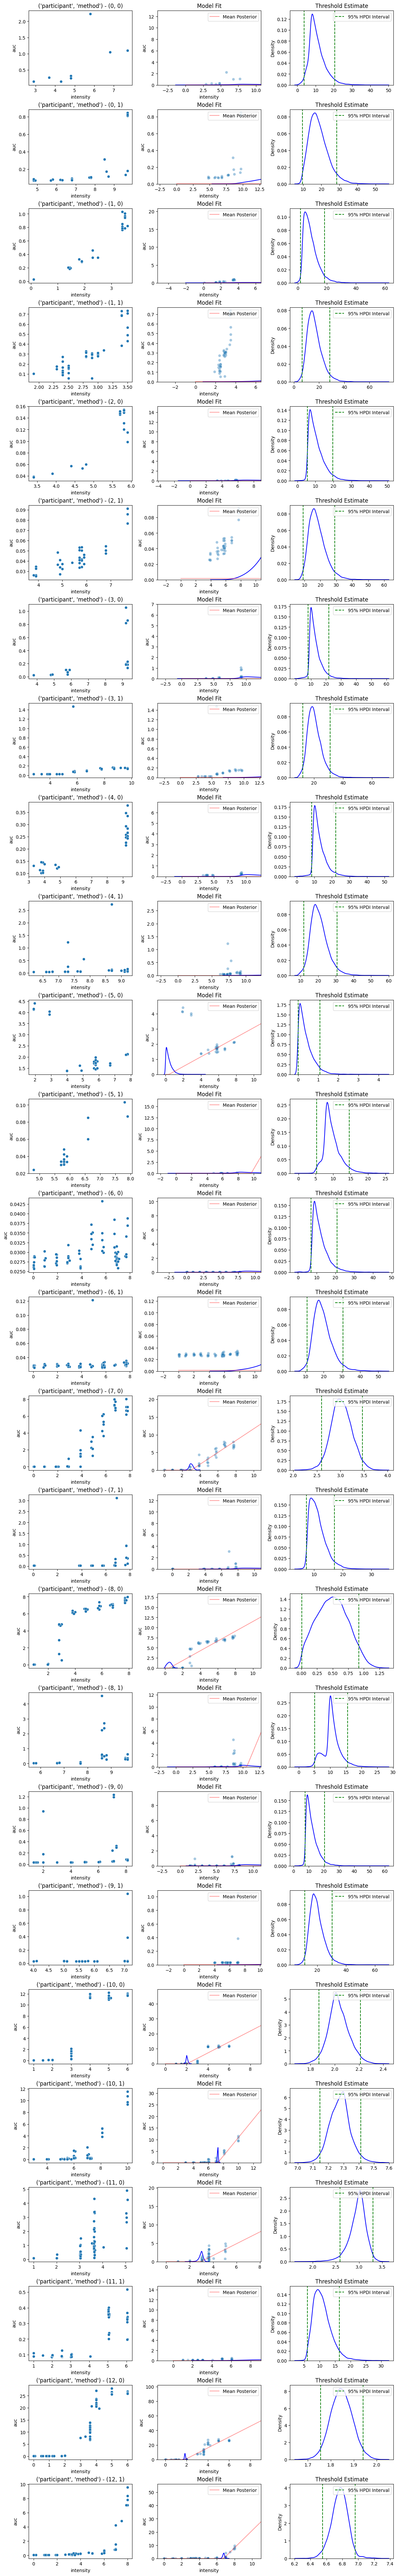

In [10]:
model.plot(df=df, posterior_samples=posterior_samples);

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

samples = posterior_samples["delta_mean"]
pr = (samples > 0).mean()

sns.kdeplot(samples)
plt.title(f"$\Pr (delta > 0) = {pr : .04}$")
plt.xlabel(f"$delta = Midline - Lateral$");

NameError: name 'posterior_samples' is not defined